In [57]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Conv1D
from keras.optimizers import SGD
from numpy.random import uniform
import keras
from tensorflow.keras import layers

In [58]:
def generate_mixed_shape(shape1, shape2, shape3, shape4):
    shape = []
    shape.extend(shape1[:15].tolist())
    shape.extend(shape2[15:30].tolist())
    shape.extend(shape3[30:45].tolist())
    shape.extend(shape4[45:60].tolist())
    return pd.DataFrame([shape])

In [59]:
def generate_noisy_shape(shape):
    noisyShape = []
    for val in shape:
        noisyShape.append(val + uniform(-0.3, 0.3))
    return pd.DataFrame([noisyShape])

In [60]:
symbol_data = pd.read_csv("runesheet.csv", header=None)
X = symbol_data.iloc[:, :-1]
Y = symbol_data.iloc[:,-1:]
Y = Y.replace("Time", 0)
Y = Y.replace("Wind", 1)

for i in range(100):
    random_symbols = X.sample(n=4)
    X = pd.concat([X, generate_mixed_shape(random_symbols.iloc[0], random_symbols.iloc[1], random_symbols.iloc[2], random_symbols.iloc[3])])
    Y = pd.concat([Y, pd.DataFrame([2], columns =[60])])
 
for i in range(100):
    random_symbol = X.sample(n=1)
    X = pd.concat([X, pd.DataFrame(generate_noisy_shape(random_symbol.iloc[0]))])
    Y = pd.concat([Y, pd.DataFrame([2], columns =[60])])

x_train, x_test, y_train, y_test = train_test_split(np.array(X), Y, test_size=0.20)


y_test = y_test.values.flatten()
y_train = y_train.values.flatten()

In [61]:
x_train_3d = [np.array(x_train[i]).reshape(-1, 3) for i in range(len(x_train))]
x_test_3d = [np.array(x_test[i]).reshape(-1, 3) for i in range(len(x_test))]

x_train_3d = tf.stack(x_train_3d)
x_test_3d = tf.stack(x_test_3d)

In [62]:
print(x_test_3d)

tf.Tensor(
[[[4.237548e-03 9.607775e-01 1.306640e-06]
  [2.061889e-01 9.442531e-01 4.057086e-05]
  [4.017783e-01 9.296216e-01 6.573173e-05]
  ...
  [2.457190e-01 6.611287e-01 6.046515e-05]
  [1.129363e-01 8.064693e-01 3.977765e-05]
  [6.671949e-02 1.000000e+00 0.000000e+00]]

 [[2.471066e-01 7.932203e-01 1.613380e-04]
  [4.538770e-01 7.588293e-01 2.099387e-04]
  [6.556321e-01 7.336606e-01 2.389850e-04]
  ...
  [3.350233e-01 6.479304e-01 7.524882e-05]
  [1.897768e-01 8.206309e-01 2.107760e-05]
  [1.595774e-01 8.670112e-01 7.383891e-06]]

 [[0.000000e+00 2.603798e-01 0.000000e+00]
  [8.989055e-02 1.417963e-01 1.873172e-05]
  [2.110130e-01 6.699613e-02 4.659815e-05]
  ...
  [6.940861e-01 4.659708e-01 8.650569e-05]
  [6.602351e-01 4.458355e-01 6.623095e-05]
  [6.602351e-01 4.458355e-01 6.623095e-05]]

 ...

 [[2.570388e-02 9.841479e-01 5.753704e-05]
  [2.461820e-01 9.909400e-01 9.400595e-05]
  [4.604935e-01 9.931352e-01 1.078419e-04]
  ...
  [3.162277e-01 6.610068e-01 8.446259e-05]
  [1.43

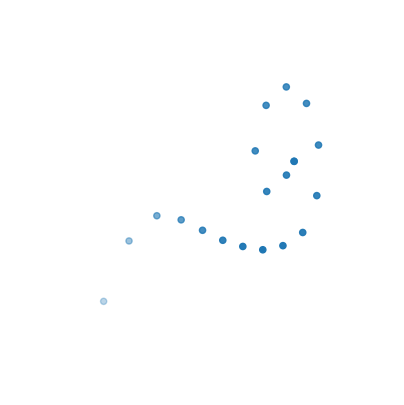

In [63]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection="3d")
points = x_train_3d[4]
ax.scatter(points[:, 0], points[:, 1], points[:, 2])
ax.set_axis_off()
ax.view_init(elev=90, azim=0, roll=90)
plt.show()

In [64]:
def augment(points, label):
    # jitter points
    points += tf.random.uniform(points.shape, -0.005, 0.005, dtype=tf.float64)
    # shuffle points
    points = tf.random.shuffle(points)
    return points, label

In [65]:
NUM_POINTS = 20
NUM_CLASSES = 3
BATCH_SIZE = 32

train_dataset = tf.data.Dataset.from_tensor_slices((x_train_3d, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test_3d, y_test))

train_dataset = train_dataset.shuffle(len(x_train_3d)).map(augment).batch(BATCH_SIZE)
test_dataset = test_dataset.shuffle(len(x_test_3d)).batch(BATCH_SIZE)

In [66]:
train_dataset

<BatchDataset element_spec=(TensorSpec(shape=(None, 20, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [67]:
def conv_bn(x, filters):
    x = layers.Conv1D(filters, kernel_size=1, padding="valid")(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)


def dense_bn(x, filters):
    x = layers.Dense(filters)(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)

In [68]:
class OrthogonalRegularizerTest(keras.regularizers.Regularizer):
    def __init__(self, num_features, l2reg=0.001):
        self.num_features = num_features
        self.l2reg = l2reg
        self.eye = tf.eye(num_features)

    def __call__(self, x):
        x = tf.reshape(x, (-1, self.num_features, self.num_features))
        xxt = tf.tensordot(x, x, axes=(2, 2))
        xxt = tf.reshape(xxt, (-1, self.num_features, self.num_features))
        return tf.reduce_sum(self.l2reg * tf.square(xxt - self.eye))
    
    def get_config(self):
        return {'num_features': float(self.num_features), 'l2reg': float(self.l2reg)}

In [69]:
type(tf.eye(3))

tensorflow.python.framework.ops.EagerTensor

In [70]:
def tnet(inputs, num_features):

    # Initalise bias as the indentity matrix
    bias = keras.initializers.Constant(np.eye(num_features).flatten())
    reg = OrthogonalRegularizerTest(num_features)

    x = conv_bn(inputs, 32)
    x = conv_bn(x, 64)
    x = conv_bn(x, 512)
    x = layers.GlobalMaxPooling1D()(x)
    x = dense_bn(x, 256)
    x = dense_bn(x, 128)
    x = layers.Dense(
        num_features * num_features,
        kernel_initializer="zeros",
        bias_initializer=bias,
        activity_regularizer=reg,
    )(x)
    feat_T = layers.Reshape((num_features, num_features))(x)
    # Apply affine transformation to input features
    return layers.Dot(axes=(2, 1))([inputs, feat_T])

In [71]:
inputs = keras.Input(shape=(NUM_POINTS, 3))

x = tnet(inputs, 3)
x = conv_bn(x, 32)
x = conv_bn(x, 32)
x = tnet(x, 32)
x = conv_bn(x, 32)
x = conv_bn(x, 64)
x = conv_bn(x, 512)
x = layers.GlobalMaxPooling1D()(x)
x = dense_bn(x, 256)
x = layers.Dropout(0.3)(x)
x = dense_bn(x, 128)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs, name="pointnet")
model.summary()

Model: "pointnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 20, 3)]      0           []                               
                                                                                                  
 conv1d_65 (Conv1D)             (None, 20, 32)       128         ['input_13[0][0]']               
                                                                                                  
 batch_normalization_103 (Batch  (None, 20, 32)      128         ['conv1d_65[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation_103 (Activation)    (None, 20, 32)       0           ['batch_normalization_103[

 activation_112 (Activation)    (None, 20, 512)      0           ['batch_normalization_112[0][0]']
                                                                                                  
 global_max_pooling1d_20 (Globa  (None, 512)         0           ['activation_112[0][0]']         
 lMaxPooling1D)                                                                                   
                                                                                                  
 dense_59 (Dense)               (None, 256)          131328      ['global_max_pooling1d_20[0][0]']
                                                                                                  
 batch_normalization_113 (Batch  (None, 256)         1024        ['dense_59[0][0]']               
 Normalization)                                                                                   
                                                                                                  
 activatio

In [72]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=["sparse_categorical_accuracy"],
)

model.fit(train_dataset, epochs=20, validation_data=test_dataset)

Epoch 1/20
15/15 [==============================] - 11s 159ms/step - loss: 2.2547 - sparse_categorical_accuracy: 0.7854 - val_loss: 1.6163 - val_sparse_categorical_accuracy: 0.8583
Epoch 2/20
15/15 [==============================] - 1s 88ms/step - loss: 1.5829 - sparse_categorical_accuracy: 0.8813 - val_loss: 1.6493 - val_sparse_categorical_accuracy: 0.8833
Epoch 3/20
15/15 [==============================] - 2s 105ms/step - loss: 1.4582 - sparse_categorical_accuracy: 0.8896 - val_loss: 1.4933 - val_sparse_categorical_accuracy: 0.8833
Epoch 4/20
15/15 [==============================] - 1s 98ms/step - loss: 1.4060 - sparse_categorical_accuracy: 0.9146 - val_loss: 1.3649 - val_sparse_categorical_accuracy: 0.9250
Epoch 5/20
15/15 [==============================] - 1s 83ms/step - loss: 1.3573 - sparse_categorical_accuracy: 0.9229 - val_loss: 1.3087 - val_sparse_categorical_accuracy: 0.9250
Epoch 6/20
15/15 [==============================] - 1s 79ms/step - loss: 1.3854 - sparse_categorical_a

1/1 [==============================] - 1s 1s/step


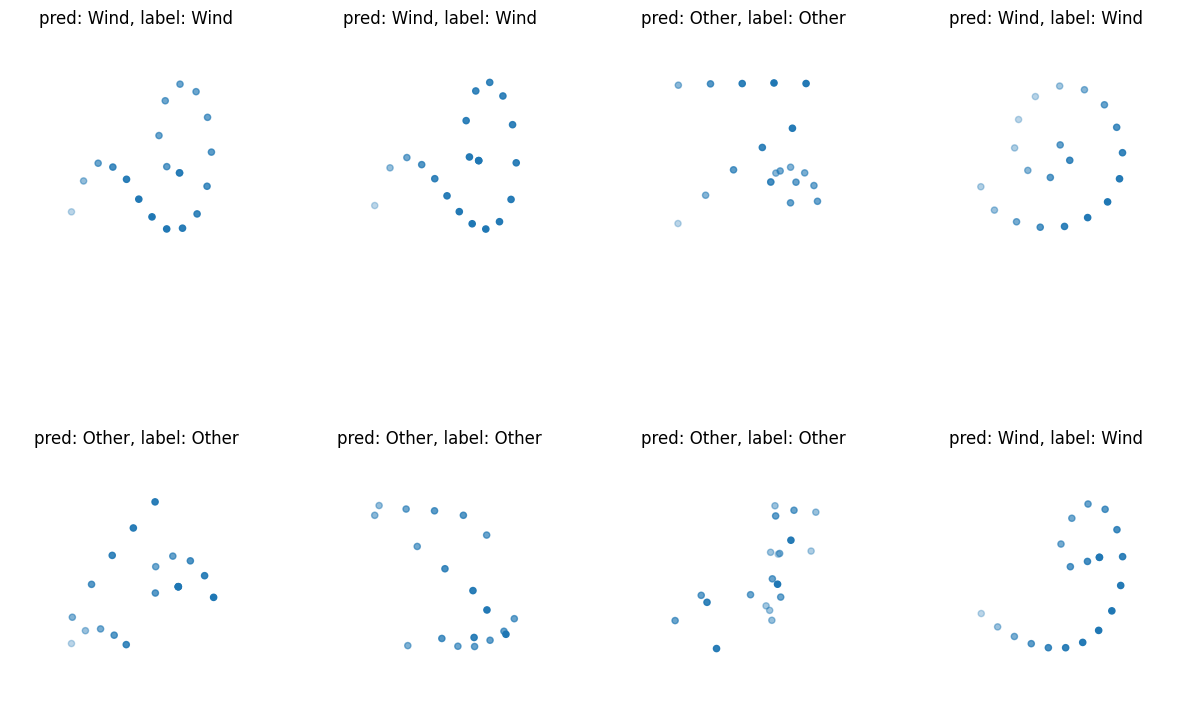

In [73]:
class_map = {}
class_map[0] = "Time"
class_map[1] = "Wind"
class_map[2] = "Other"

data = test_dataset.take(1)

points, labels = list(data)[0]
points = points[:8, ...]
labels = labels[:8, ...]

# run test data through model
preds = model.predict(points)
preds = tf.math.argmax(preds, -1)

points = points.numpy()

# plot points with predicted class and label
fig = plt.figure(figsize=(15, 10))
for i in range(8):
    ax = fig.add_subplot(2, 4, i + 1, projection="3d")
    ax.scatter(points[i, :, 0], points[i, :, 1], points[i, :, 2])
    ax.set_title(
        "pred: {:}, label: {:}".format(
            class_map[preds[i].numpy()], class_map[labels.numpy()[i]]
        )
    )
    ax.set_axis_off()    
    ax.view_init(elev=90, azim=0, roll=90)
plt.show()


In [74]:
model.save('model_3d_with_other')

INFO:tensorflow:Assets written to: model_3d_with_other\assets


INFO:tensorflow:Assets written to: model_3d_with_other\assets


In [ ]:
model.evaluate(test_dataset)

In [ ]:
inverted_rune_data = pd.read_csv("InvertedRunes.csv", header=None)
inverted_runes_X = inverted_rune_data.iloc[:, :-1]

inverted_runes_Y = inverted_rune_data.iloc[:,-1:]
inverted_runes_Y = inverted_runes_Y.replace("Time", 0)
inverted_runes_Y = inverted_runes_Y.replace("Wind", 1)

inverted_runes_X_3d = [np.array(inverted_runes_X[i]).reshape(-1, 3) for i in range(len(inverted_runes_X))]
inverted_runes_X_3d = tf.stack(inverted_runes_X_3d)

In [ ]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection="3d")
points = inverted_runes_X_3d[2]
ax.scatter(points[:, 0], points[:, 1], points[:, 2])
ax.set_axis_off()
ax.view_init(elev=90, azim=0, roll=90)
plt.show()

In [75]:
test_model = keras.models.load_model('model_3d_with_other')
test_model.evaluate(test_dataset)

ValueError: Unknown regularizer: OrthogonalRegularizerTest. Please ensure this object is passed to the `custom_objects` argument. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.